In [177]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import pyfixest as pf
from IPython.display import Markdown, display
import warnings
warnings.simplefilter('ignore')




In [178]:
#import txt data
exp= pd.read_csv('/Users/ryanscholte/Desktop/GitHub/HW5/data/output/medicaid_expansion.txt', sep='\t')

medicaid= pd.read_csv('/Users/ryanscholte/Desktop/GitHub/HW5/data/output/acs_medicaid.txt', sep='\t')

insurance= pd.read_csv('/Users/ryanscholte/Desktop/GitHub/HW5/data/output/acs_insurance.txt', sep='\t')


In [179]:
medicaid= medicaid[~medicaid['State'].isin(['District of Columbia', 'Puerto Rico'])]
#give medicaid summary statistics
print(medicaid.describe())

              year     adult_pop  ins_employer    ins_direct  ins_medicare  \
count   400.000000  4.000000e+02  4.000000e+02  4.000000e+02     400.00000   
mean   2015.500000  3.881077e+06  2.193638e+06  3.127943e+05   47919.51750   
std       2.294157  4.375757e+06  2.355459e+06  3.906798e+05   47407.01891   
min    2012.000000  3.293650e+05  1.947960e+05  1.553400e+04    1532.00000   
25%    2013.750000  1.098706e+06  5.548062e+05  8.343075e+04   10979.50000   
50%    2015.500000  2.686457e+06  1.440655e+06  2.021255e+05   33369.50000   
75%    2017.250000  4.445620e+06  2.729329e+06  3.521965e+05   66472.75000   
max    2019.000000  2.445185e+07  1.321647e+07  2.427618e+06  235939.00000   

       ins_medicaid     uninsured  expand_year  
count  4.000000e+02  4.000000e+02   264.000000  
mean   4.038630e+05  5.831027e+05  2014.515152  
std    6.029094e+05  8.497917e+05     1.260604  
min    9.975000e+03  2.098300e+04  2014.000000  
25%    7.726400e+04  1.347552e+05  2014.000000  
50%

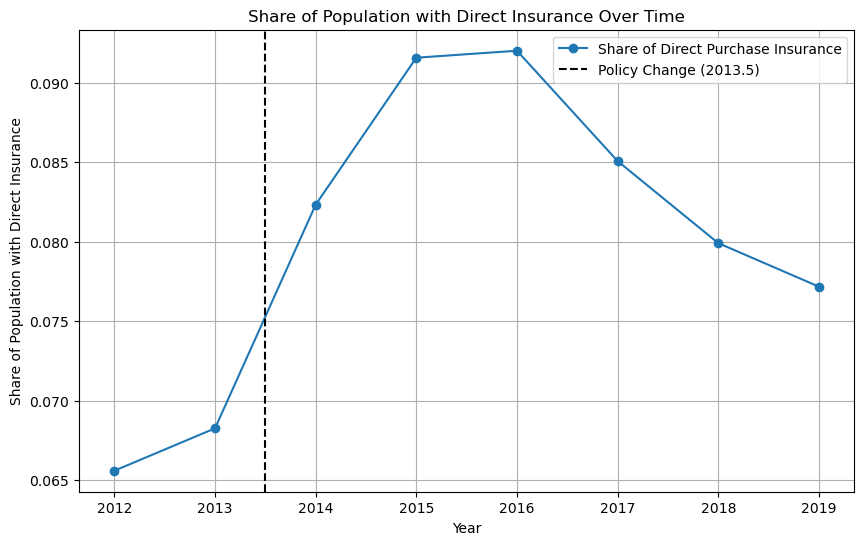

In [180]:
# Q1
# Group by year and calculate the mean percentage of direct insurance
medicaid['perc_direct'] = medicaid["ins_direct"] / medicaid["adult_pop"]
Share = medicaid.groupby("year")["perc_direct"].mean().reset_index()

# Plotting the national share of direct purchase insurance
plt.figure(figsize=(10, 6))
plt.plot(Share["year"], Share["perc_direct"], marker='o', label='Share of Direct Purchase Insurance')
plt.axvline(x=2013.5, color="black", linestyle="--", label="Policy Change (2013.5)")
plt.title('Share of Population with Direct Insurance Over Time')
plt.legend()
plt.xlabel('Year')
plt.ylabel('Share of Population with Direct Insurance')
plt.grid()
plt.show()


# Q2


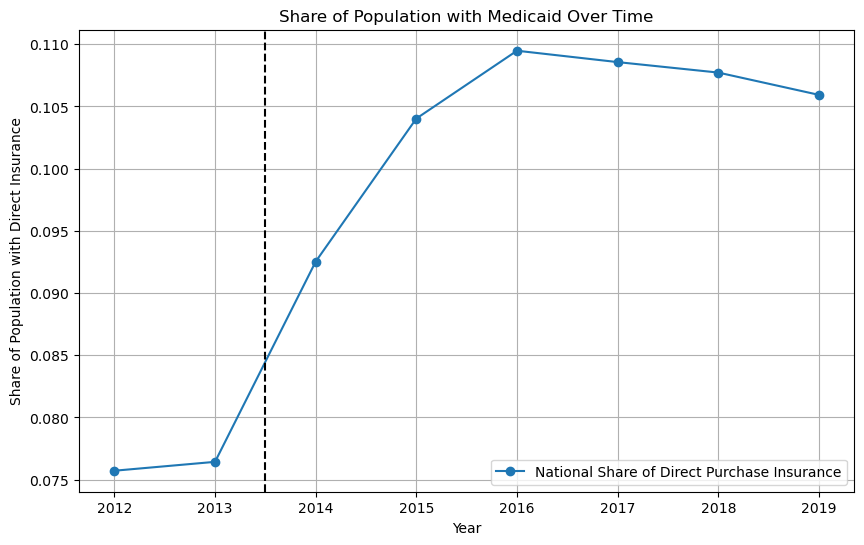

In [181]:
#Q3
medicaid['perc_MA'] = medicaid["ins_medicaid"] / medicaid["adult_pop"]
Share_MA = medicaid.groupby("year")["perc_MA"].mean().reset_index()

# Plotting the national share of direct purchase insurance
plt.figure(figsize=(10, 6))
plt.plot(Share_MA['year'], Share_MA['perc_MA'], marker='o', label='National Share of Direct Purchase Insurance')
plt.axvline(x=2013.5, color="black", linestyle="--")
plt.grid()
plt.title('Share of Population with Medicaid Over Time')
plt.legend()
plt.xlabel('Year')
plt.ylabel('Share of Population with Direct Insurance')
plt.show()



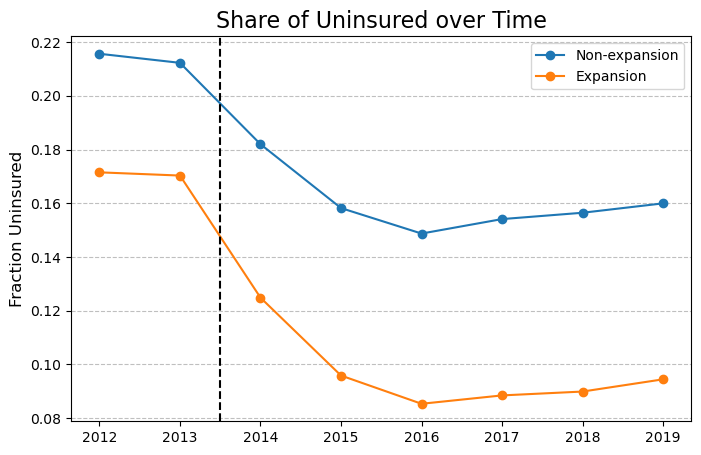

In [182]:
medicaid['date_adopted'] = pd.to_datetime(medicaid['date_adopted'])

# Filter data for states that expanded Medicaid in 2014 or earlier or never expanded
ins_plot_data = medicaid[medicaid["expand_year"].isna() | (medicaid["expand_year"] <= 2014)]

# Calculate uninsured share for all rows
ins_plot_data["uninsured_share"] = ins_plot_data["uninsured"] / ins_plot_data["adult_pop"]

# Group data by expansion status and year, and calculate the mean uninsured share
ins_plot_summary = (ins_plot_data.groupby(["expand_ever", "year"])["uninsured_share"].mean().reset_index())

plt.figure(figsize=(8, 5))
for key, grp in ins_plot_summary.groupby("expand_ever"):
    plt.plot(
        grp["year"],
        grp["uninsured_share"],
        marker="o",
        label="Expansion" if key else "Non-expansion",
    )

# Add a vertical line for 2013.5 to indicate the policy change
plt.axvline(x=2013.5, color="black", linestyle="--")
plt.title("Share of Uninsured over Time", fontsize=16)
plt.xlabel("")
plt.ylabel("Fraction Uninsured", fontsize=12)
plt.grid(axis="y", color="gray", linestyle="--", alpha=0.5)
plt.legend()
plt.show()

In [183]:
print(final_data.groupby(["expanded", "year"]).size())

expanded  year
False     2012    17
          2013    17
          2014    17
          2015    17
          2016    17
          2017    17
          2018    17
          2019    17
True      2012    33
          2013    33
          2014    33
          2015    33
          2016    33
          2017    33
          2018    33
          2019    33
dtype: int64


In [184]:
#Q5

# Difference-in-Differences Table
reg_data = medicaid.copy()
reg_data = reg_data.loc[
    (reg_data["expand_year"].isna()) | (reg_data["expand_year"] == 2014)
]
reg_data = reg_data.loc[
    reg_data["year"].isin([2012, 2015])
]

reg_data['perc_unins'] = reg_data["uninsured"] / reg_data["adult_pop"]
dd_table = (
    reg_data.groupby(["expand_ever", "year"])["perc_unins"]
    .mean()
    .reset_index()
    .pivot(index="expand_ever", columns="year", values="perc_unins")
    .rename(columns={2012: "Pre", 2015: "Post"})
    .reset_index()
)
dd_table["Group"] = dd_table["expand_ever"].map({False: "Non-expansion", True: "Expansion"})
dd_table = dd_table[["Group", "Pre", "Post"]]

dd_table.index = [''] * len(dd_table)

# Display the Difference-in-Differences Table
dd_table



year,Group,Pre,Post
,Non-expansion,0.215653,0.158208
,Expansion,0.171511,0.095856


In [185]:
# 6
# Add treatment flag and stack data
reg_data = medicaid.copy()
reg_data["post"] = (reg_data["year"] >= 2014).astype(int)
reg_data["treat"] = reg_data["post"] * reg_data["expand_ever"].astype(int)
reg_data = reg_data[(reg_data["expand_year"].isna()) | (reg_data["expand_year"] == 2014)]
reg_data['perc_unins'] = medicaid["uninsured"] / medicaid["adult_pop"]
# OLS regression without FE
results = []
results.append(pf.feols("perc_unins ~ post + expand_ever + treat", data=reg_data))

results_table = pf.etable(results, type='df',
                          drop='Intercept', coef_fmt='b (se)')
results_table = results_table.drop(index=['depvar', 'S.E. type'])
results_table.columns = ['Standard DD']
results_table.index = ['Post 2014', 'Expand', 'Post x Expand', 'Num. Obs.', 'R2']
results_table = results_table.reset_index(names='')
#remove index of results_table
results_table.index = [''] * len(results_table)
results_table




,,Standard DD
,Post 2014,-0.054*** (0.008)
,Expand,-0.043*** (0.009)
,Post x Expand,-0.020* (0.010)
,Num. Obs.,344
,R2,0.508


In [186]:
#7

results.append(
    pf.feols("perc_unins ~ treat | State + year", data=reg_data))

results_table = pf.etable(results, type='df',
                          drop='Intercept', coef_fmt='b (se)')
results_table = results_table.drop(index=['depvar', 'S.E. type', 'State', 'year'])
results_table.columns = ['Standard DD', 'TWFE']
results_table.index = ['Post 2014', 'Expand', 'Post x Expand', 'Num. Obs.', 'R2']
results_table = results_table.reset_index(names='')

results_table

,,Standard DD,TWFE
0,Post 2014,-0.054*** (0.008),
1,Expand,-0.043*** (0.009),
2,Post x Expand,-0.020* (0.010),-0.020** (0.007)
3,Num. Obs.,344,344
4,R2,0.508,0.952


In [187]:
#8

# DD Regression (2014 expansion only)
reg_data2 = medicaid.copy()
reg_data2["treat"] = 0
reg_data2.loc[(reg_data2["year"] >= reg_data2["expand_year"]) & (reg_data2["expand_year"].notna()), "treat"] = 1
reg_data2['perc_unins'] = medicaid["uninsured"] / medicaid["adult_pop"]

results.append(
    pf.feols("perc_unins ~ treat | State + year", data=reg_data2)
)

results_table = pf.etable(results, type='df',
                          drop='Intercept', coef_fmt='b (se)')
results_table = results_table.drop(index=['depvar', 'S.E. type', 'State', 'year'])
results_table = results_table.iloc[:, :3]
results_table.columns = ['Standard DD', 'TWFE', 'Time-varying Treatment']
results_table.index = ['Post 2014', 'Expand', 'Post x Expand', 'Num. Obs.', 'R2']
results_table = results_table.reset_index(names='')

results_table

,,Standard DD,TWFE,Time-varying Treatment
0,Post 2014,-0.054*** (0.008),,
1,Expand,-0.043*** (0.009),,
2,Post x Expand,-0.020* (0.010),-0.020** (0.007),-0.023*** (0.005)
3,Num. Obs.,344,344,400
4,R2,0.508,0.952,0.950


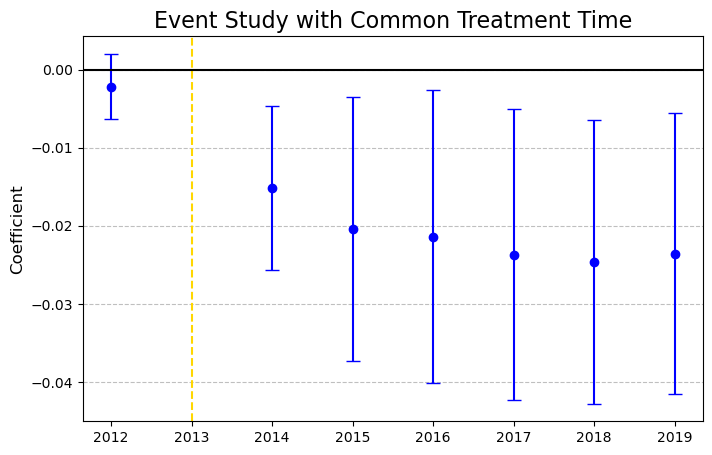

In [188]:
#9
# Event Study with constant treatment
reg_data["relative_year"] = (reg_data["year"] - reg_data["expand_year"]).fillna(np.inf)

dynamic_twfe = pf.feols("perc_unins ~ i(relative_year, ref=-1) | State + year",
                 data=reg_data, vcov={"CRV1": "State"})

plt.figure(figsize=(8, 5))
joint_ci = dynamic_twfe.coef() - dynamic_twfe.confint(joint=True).T.iloc[0, :]
plt.errorbar(np.delete(np.arange(2012, 2020), 1), dynamic_twfe.coef(), 
             yerr=joint_ci, fmt='o', color='blue', capsize=5)
plt.axvline(x=2013, color="gold", linestyle="--")
plt.axhline(y=0, color="black", linestyle="-")
plt.title("Event Study with Common Treatment Time", fontsize=16)
plt.ylabel("Coefficient", fontsize=12)
plt.grid(axis='y', color='gray', linestyle='--', alpha=0.5)
plt.show()




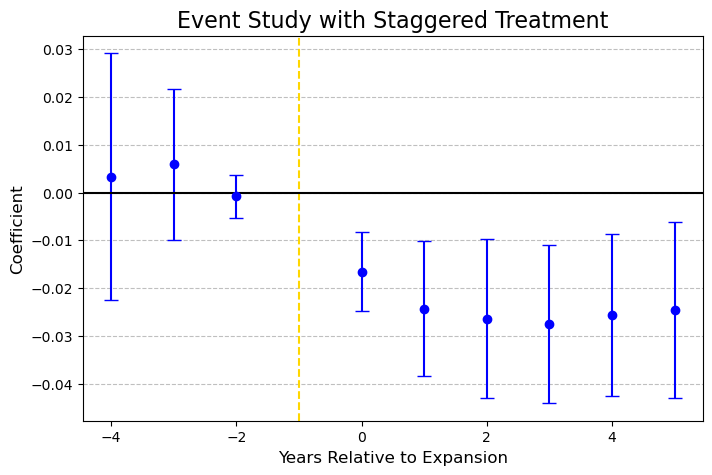

In [189]:
#10 
reg_data2= medicaid.copy()

# ATE Q6: Event Study with time-varying treatment
reg_data2["relative_year"] = (reg_data2["year"] - reg_data2["expand_year"]).fillna(np.inf)
reg_data2["relative_year"] = reg_data2["relative_year"].clip(lower=-4)
reg_data2['perc_unins'] = medicaid["uninsured"] / medicaid["adult_pop"]

dynamic_twfe2 = pf.feols("perc_unins ~ i(relative_year, ref=-1) | State + year",
                  data=reg_data2, vcov={"CRV1": "State"})

plt.figure(figsize=(8, 5))
joint_ci2 = dynamic_twfe2.coef() - dynamic_twfe2.confint(joint=True).T.iloc[0, :]
plt.errorbar(np.delete(np.arange(-4, 6), 3), dynamic_twfe2.coef(), 
             yerr=joint_ci2, fmt='o', color='blue', capsize=5)
plt.axvline(x=-1, color="gold", linestyle="--")
plt.axhline(y=0, color="black", linestyle="-")
plt.title("Event Study with Staggered Treatment", fontsize=16)
plt.ylabel("Coefficient", fontsize=12)
plt.xlabel("Years Relative to Expansion", fontsize=12)
plt.grid(axis='y', color='gray', linestyle='--', alpha=0.5)
plt.show()
